In [1]:
import sys
sys.path.append('../../')
sys.path.append('../../ray-delay')
from stim_surface_code.patch import SurfaceCodePatch
from stim_surface_code.memory import MemoryPatch
from stim_lattice_surgery.lattice_surgery.zxxz_patch import ZXXZPatch
from stim_lattice_surgery.lattice_surgery.glue import GluePatch, BoundaryType
from stim_lattice_surgery.lattice_surgery.surgery_op import SurgeryOp
from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.noise_model import GoogleNoiseParamsNoRandomRays
import numpy as np

import sinter
import matplotlib.pyplot as plt

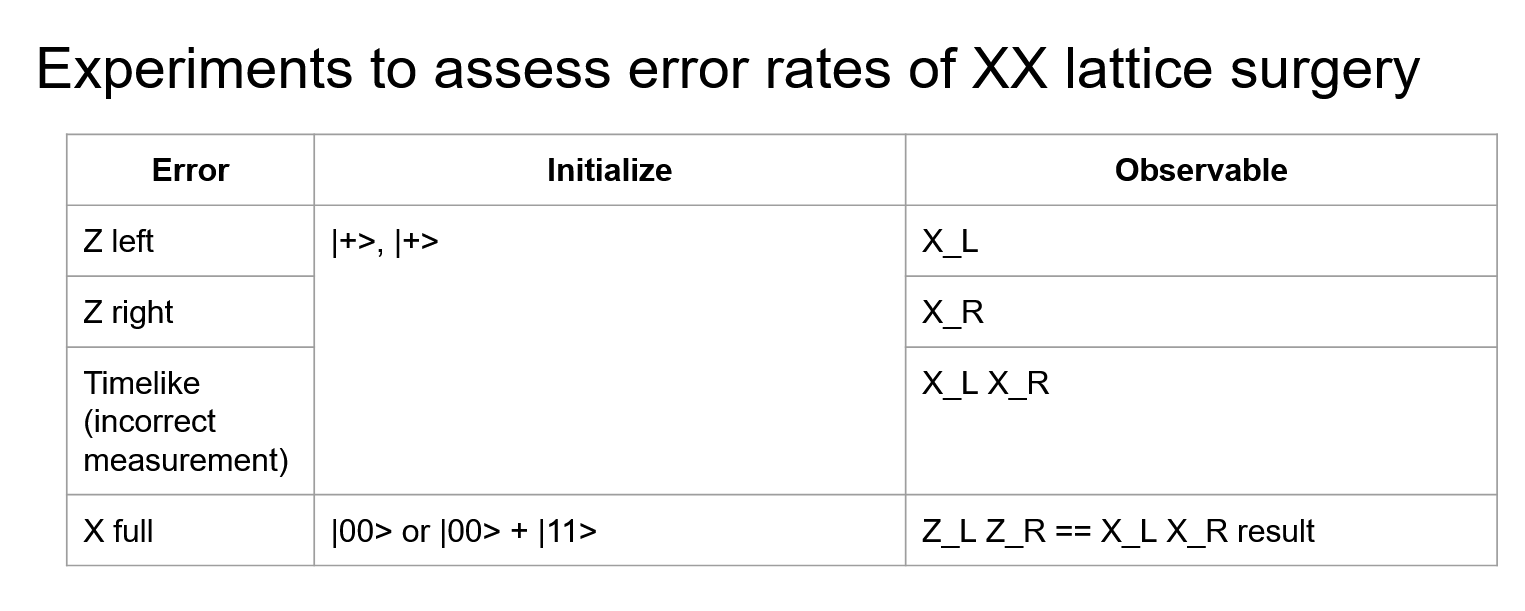

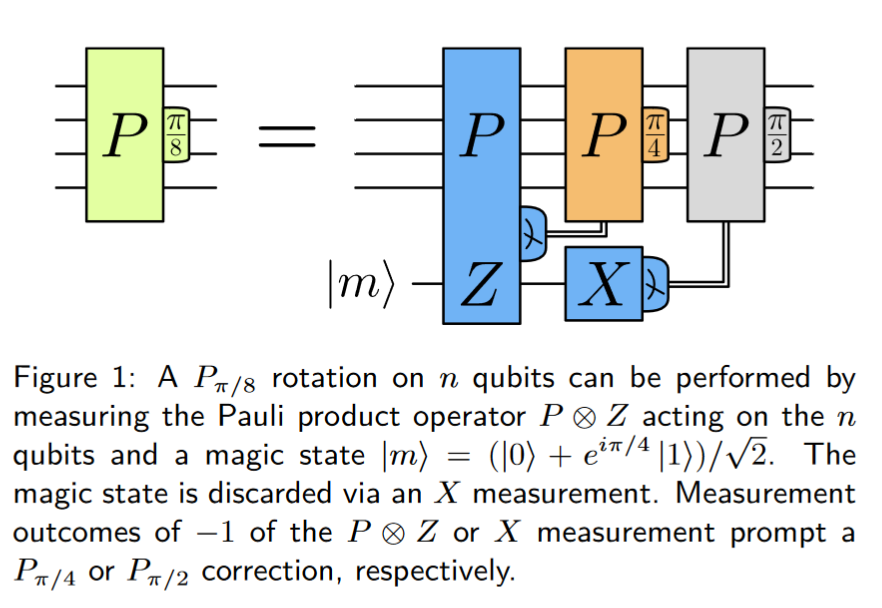

Recall that the notation $P_\theta = \exp (- i \theta P)$ so that $P_{\pi / 8} = T, P_{\pi / 4} = S, P_{\pi / 2} = Z$. 

There are four error mechanisms at play for our ZZ lattice surgery on qubits $0, 1$:
1. $X_0$ $(p_0)$ ($00 \mapsto 10$).
2. $X_1$ $(p_1)$ ($00 \mapsto 01$). 
3. Timelike $(p_{TL})$ (incorrectly perform $P_{\pi / 4}$ gate). 
4. $Z$ full $(p_F)$ $00 + 11 \mapsto 00 - 11$. 
Call $\ket{\psi}$ to be $0$ and $\ket{T}$ to be $1$. Then,

The error mechanisms act in the following ways:
1. $X_0$ is a logical $X$ error, which damages all previous / future gates, this should be avoided.
2. $X_1$ is a logical $X$ error on the ancilla, which doesn't matter as this additional $X$ gate will commute with the measurement.
3. We will accidently perform an additional (or missing) $P_{\pi / 4}$ gate. This is an additional $S$ gate. This counts as a half error if it occurs on the top qubit via projector logic.
4. The $Z$ error can be thought to act only on the $\ket{m}$ state, as the entire state is stabilized by $ZZ$. We perform an additional $P_{\pi / 2}$ gate, a full $Z$ error.





So that:
$$
E = p_0 + 0 \cdot p_1 + \frac{1}{2} p_{TL} + p_F
$$

Projector logic.

Suppose that, as we had seen earlier, had a $Z$ fault in our magic state. In the ZZ measurement phase, this has no impact on our entangled state, but it does affect the $X$ measurement and thus erroneously applies some $Z...Z$ string.

At the end of computation, we ideally would have some $\ket{\psi}$ which reads out all $+1$s on the $X$ measurements, i.e. $\Pi_{i} \ket{\psi} = \ket{\psi}$. However, our erroneous $Z$ string can be thought of as the following:
$$
Z_0 Z_i \ket{\psi} =  Z_0 Z_i \Pi_i \ket{\psi} = Z_0 Z_i \frac{I + X_i}{2} \ket{\psi} = \frac{I - X_i}{2} Z_0 Z_i \ket{\psi}
$$
So that we now measure a $-1$ on that qubit, alongside effecting a $Z$ error on the output qubit. 

To consider the $S$ case, note that $P_{\pi / 4} = \cos \frac{\pi}{4} I - i \sin \frac{\pi}{4} Z...Z$ for some $Z$ string. To simplify, we may write this as $\frac{I - i Z}{\sqrt{2}}$. Then:
$$
\frac{I - i Z_0 Z_k}{\sqrt{2}} \frac{I + X_k}{2} = \frac{I + X_k}{2} \frac{I}{\sqrt{2}} + \frac{I - X_k}{2} \frac{-i Z_0 Z_k}{\sqrt{2}}
$$
I.e. there is a 50\% chance of measuring a $1$, in which case we project a $Z$ error onto the output qubit. 

## Single Qubit Errors, $p_0, p_1$
We use a ZZ merge to estimate the error rate, looking for X failures:
1. Prep $\ket{0}, \ket{0}$
2. ZZ merge
3. Check $X_0, X_1$ stabilizers

In [2]:
# p_range = [1e-4, 1e-3, 1e-2]
p_range = np.geomspace(1e-4, 1e-2, 5)
d_range = np.array([5,7,9])

ray_radius = [4, 6, 8, 10]
init_basis = 'Z'
observable_basis = 'Z'
tasks = []
for d in d_range:
    patch1 = ZXXZPatch(d, d, d, id_offset=0)
    patch2 = ZXXZPatch(d, d, d, id_offset=2*d**2 - 1)
    zz_op = SurgeryOp([patch1, patch2], [], [(patch1, BoundaryType.TOP, patch2, BoundaryType.BOTTOM, 4*d**2 - 2)])
    
    #xx_op = SurgeryOp([patch1, patch2], [], [(patch1, BoundaryType.RIGHT, patch2, BoundaryType.LEFT, 4*d**2)])
    for p in p_range:
        noise_params = GoogleNoiseParamsNoRandomRays.improve(10)
        noise_params.error_means = {'T1': 1, 'T2': 1, 'readout_err': p, 'gate1_err': p, 'gate2_err': p, 'erasure':0}
        cosmic_noise = NoiseModelPatch(zz_op.patch_collection, noise_params)
        print(zz_op.patch_collection.error_vals['gate1_err'][0])
        circ = zz_op.get_stim(init_basis=init_basis, observable_basis=observable_basis, meas_mode="01TL", expect_bell=True)
        tasks.append(sinter.Task(circuit=circ, json_metadata={'p': p, 'd': int(d)}))
        
        # dem = circ.detector_error_model(decompose_errors=True, approximate_disjoint_errors=True)
        # assert dem.num_detectors + dem.num_observables == circ.count_determined_measurements()

0.00010842162589179949
0.00031170245165969865
0.0010063167712044043
0.003158074358565358
0.009999863277812725
0.00010362902014472011
0.00031871398206341506
0.0010042208626677626
0.0031629260165551096
0.010001786815548216
0.00010146691216344995
0.00032146853748228117
0.0009956016028378003
0.0031693563438540393
0.009994540807365351


In [3]:
circ

stim.Circuit('''
    QUBIT_COORDS(20, 2) 81
    QUBIT_COORDS(20, 6) 82
    QUBIT_COORDS(20, 10) 83
    QUBIT_COORDS(20, 14) 84
    QUBIT_COORDS(22, 4) 86
    QUBIT_COORDS(22, 8) 88
    QUBIT_COORDS(22, 12) 90
    QUBIT_COORDS(22, 16) 92
    QUBIT_COORDS(24, 2) 95
    QUBIT_COORDS(24, 6) 97
    QUBIT_COORDS(24, 10) 99
    QUBIT_COORDS(24, 14) 101
    QUBIT_COORDS(26, 4) 104
    QUBIT_COORDS(26, 8) 106
    QUBIT_COORDS(26, 12) 108
    QUBIT_COORDS(26, 16) 110
    QUBIT_COORDS(28, 2) 113
    QUBIT_COORDS(28, 6) 115
    QUBIT_COORDS(28, 10) 117
    QUBIT_COORDS(28, 14) 119
    QUBIT_COORDS(30, 4) 122
    QUBIT_COORDS(30, 8) 124
    QUBIT_COORDS(30, 12) 126
    QUBIT_COORDS(30, 16) 128
    QUBIT_COORDS(32, 2) 131
    QUBIT_COORDS(32, 6) 133
    QUBIT_COORDS(32, 10) 135
    QUBIT_COORDS(32, 14) 137
    QUBIT_COORDS(34, 4) 140
    QUBIT_COORDS(34, 8) 142
    QUBIT_COORDS(34, 12) 144
    QUBIT_COORDS(34, 16) 146
    QUBIT_COORDS(36, 2) 149
    QUBIT_COORDS(36, 6) 151
    QUBIT_COORDS(36, 10) 1

In [4]:
samples_xxtl = sinter.collect(
    num_workers=4,
    max_shots=10_000_000,
    max_errors=100,
    tasks=tasks,
    decoders=['pymatching'],
    count_observable_error_combos=True,
)

In [14]:
samples_xxtl[0].custom_counts

Counter({'obs_mistake_mask=E__': 48,
         'obs_mistake_mask=_E_': 37,
         'obs_mistake_mask=E_E': 26,
         'obs_mistake_mask=_EE': 3})

In [15]:
# let's filter for the mechanisms corresponding to __E, _EE, E_E (eq 3-5 in Chamberland)
valid_mechanisms = ["__E", "_EE", "E_E", "E__", "_E_"]

# get and store relevant data for plotting
data_xxtl = np.zeros((len(d_range), len(p_range), len(valid_mechanisms) + 1))

for sample in samples_xxtl:
    d = sample.json_metadata['d']
    p = sample.json_metadata['p']
    d_idx = np.where(d_range == d)[0][0]
    p_idx = np.where(p_range == p)[0][0]
    
    for mechanism, errs in sample.custom_counts.items():
        mech_name = mechanism.split("=")[1]
        if mech_name in valid_mechanisms:
            mechanism_idx = valid_mechanisms.index(mech_name)
            data_xxtl[d_idx, p_idx, mechanism_idx] = errs / sample.shots
        else:
            data_xxtl[d_idx, p_idx, -1] += errs
        
    data_xxtl[d_idx, p_idx, -1] = data_xxtl[d_idx, p_idx, -1] / sample.shots


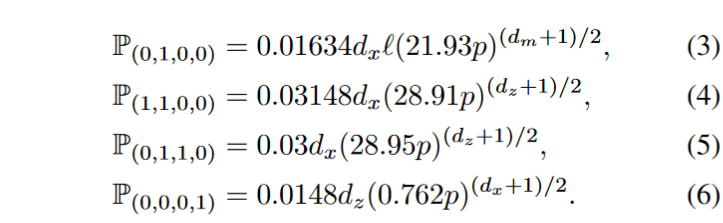

In [6]:
# chamberland polynomials
def cp_001(p, dz, dx, dm, l):
    return 0.01634 * dx * l * (21.93 * p)**((dm + 1) / 2)

def cp_101(p, dz, dx, dm, l):
    return 0.03148 * dx * (28.91 * p)**((dz + 1) / 2)

def cp_011(p, dz, dx, dm, l):
    return 0.03 * dx * (28.95 * p)**((dz + 1) / 2)

cps = [cp_001, cp_011, cp_101]

In [23]:
np.min(data_xxtl)

0.0

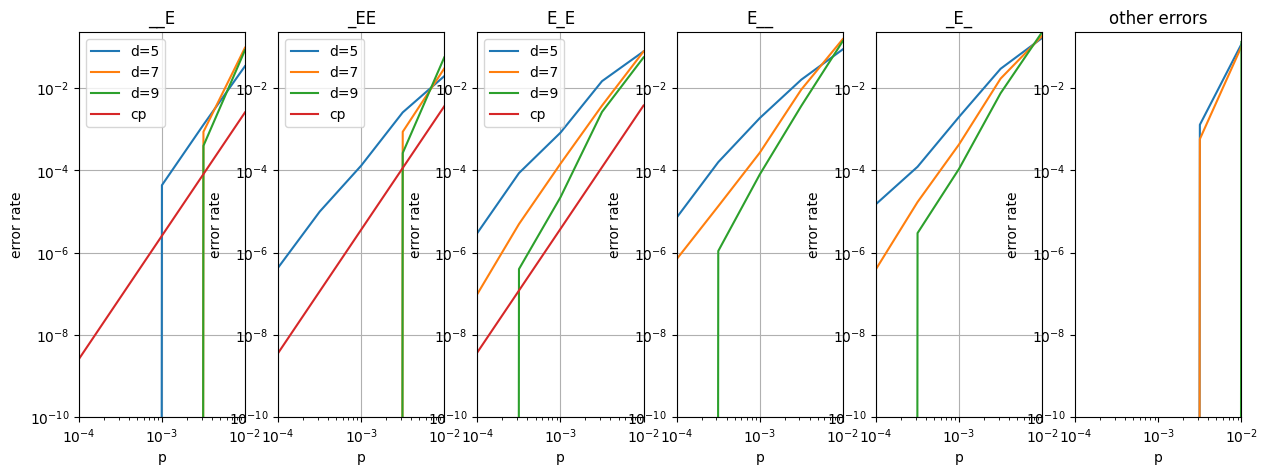

In [25]:
# plot three separate plots for each mechanism
fig, axs = plt.subplots(1, len(valid_mechanisms) + 1, figsize=(15, 5))
plt.setp(axs, xlim=(min(p_range), max(p_range)), ylim=(np.min(data_xxtl) + 1e-10, np.max(data_xxtl)))


for i, mechanism in enumerate(valid_mechanisms):
    for d_idx, d in enumerate(d_range):
        axs[i].plot(p_range, data_xxtl[d_idx, :, i], label=f'd={d}')
    
    axs[i].set_title(mechanism)
    axs[i].set_xlabel('p')
    axs[i].set_ylabel('error rate')
    axs[i].set_xscale('log')
    axs[i].grid()
    axs[i].set_yscale('log')

# add chamberland rates
for i, mechanism in enumerate(valid_mechanisms):
    if i <= 2:
        axs[i].plot(p_range, cps[i](p_range, 5, 5, 5, 3), label='cp')
        axs[i].legend()

# add other errors to the last plot
for d_idx, d in enumerate(d_range):
    axs[-1].plot(p_range, data_xxtl[d_idx, :, -1], label=f'd={d}')

axs[-1].set_title('other errors')
axs[-1].set_xlabel('p')
axs[-1].set_ylabel('error rate')
axs[-1].set_xscale('log')
axs[-1].set_yscale('log')



In [27]:
def error_contribution_xxtl(sample_counts, total):
    # sample_counts from stim; total number of shots
    # full errs begin with E
    # half errs end with E
    
    total_errs = 0
    for mechanism, errs in sample_counts.items():
        mechanism_name = mechanism.split("=")[1]
        
        if mechanism_name.startswith("E"):
            total_errs += errs
        elif mechanism_name.endswith("E"):
            total_errs += errs
    
    return total_errs / total

error_contribution_xxtl(samples_xxtl[0].custom_counts, samples_xxtl[0].shots)

0.00025636757116697187

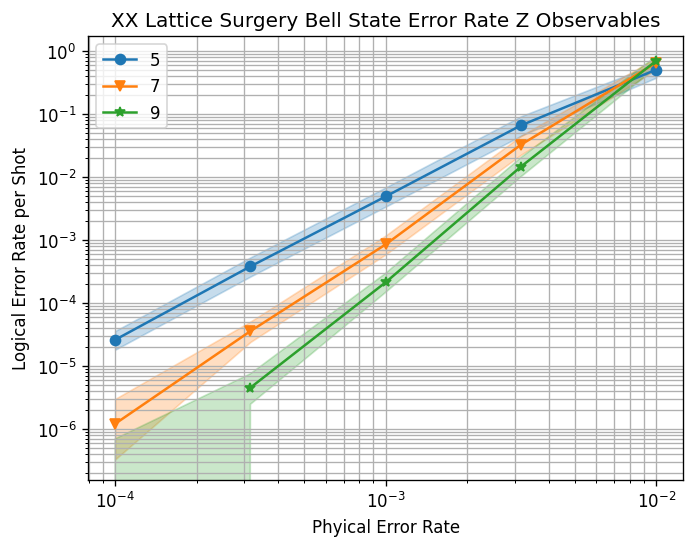

In [26]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=samples_xxtl,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title(f"XX Lattice Surgery Bell State Error Rate {observable_basis} Observables")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

last one should be ++, measure ZZ, then observable of XX is always +1 still

In [ ]:
p_range = [1e-4, 1e-3, 1e-2]
d_range = [5, 7, 9]
ray_radius = [4, 6, 8, 10]
init_basis = 'X'
observable_basis = 'X'
tasks = []
for d in d_range:
    patch1 = ZXXZPatch(d, d, d, id_offset=0)
    patch2 = ZXXZPatch(d, d, d, id_offset=2*d**2 - 1)
    zz_op = SurgeryOp([patch1, patch2], [], [(patch1, BoundaryType.TOP, patch2, BoundaryType.BOTTOM, 4*d**2 - 2)])
    cosmic_noise = NoiseModelPatch(zz_op.patch_collection)
    #xx_op = SurgeryOp([patch1, patch2], [], [(patch1, BoundaryType.RIGHT, patch2, BoundaryType.LEFT, 4*d**2)])
    for p in p_range:
        cosmic_errors = cosmic_noise.noise_model.get_error_val_dict()
        zz_op.patch_collection.set_error_vals_normal({'T1': 1, 'T2': 1, 'readout_err': p, 'gate1_err': p, 'gate2_err': p, 'erasure':0})
        # zz_op.patch_collection.error_vals['T1'] = cosmic_errors['T1']
        # zz_op.patch_collection.error_vals['T2'] = cosmic_errors['T2']
        circ = zz_op.get_stim(init_basis=init_basis, observable_basis=observable_basis, meas_mode="", expect_bell=True)
        tasks.append(sinter.Task(circuit=circ, json_metadata={'p': p, 'd': d}))

In [ ]:

samples_zl = sinter.collect(
    num_workers=4,
    max_shots=10_000_000,
    max_errors=100,
    tasks=tasks,
    decoders=['pymatching'],
    count_observable_error_combos=True,
)

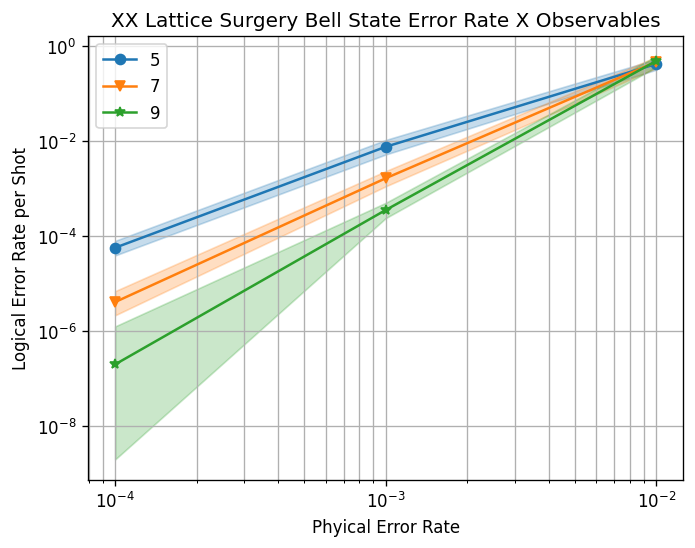

In [ ]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=samples_zl,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title(f"XX Lattice Surgery Bell State Error Rate {observable_basis} Observables")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger